# Brief Introduction

This is the 2023 revison of the **Social Media impact on the Crowdfunding Success** project. In this revison, there are a few changes made to the project. The changes are listed [here](https://www.evernote.com/shard/s458/sh/5feb1b0b-d2b6-d0d2-ce9e-1d65a87ebb81/).

In [132]:
import os
import nltk
import json
import spacy
import gensim
import pyLDAvis
import pyLDAvis.gensim_models 
import warnings
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
warnings.filterwarnings("ignore", category=DeprecationWarning)

torch.set_num_threads(4)

current_dir = r'/home/theerthala/Documents/repos/Crowdfunding-Social-Media-Drivers/Data/'

nlp = spacy.load('en_core_web_trf')
stop = stopwords.words('english')
post_data = pd.read_csv(current_dir+"2022-07-22-09-31-10-IST-feed-download.csv")


#basic data cleaning
post_data.drop_duplicates(subset=['Message'], keep='last', inplace=True)
post_data.reset_index(inplace=True, drop=True)
post_data.columns = [x.lower().replace(' ','_') for x in post_data.columns.to_list()]
post_data.drop(['user_name', 'facebook_id', 'page_category', 'page_admin_top_country',
                'overperforming_score_(weighted__—__likes_1x_shares_1x_comments_1x_love_1x_wow_1x_haha_1x_sad_1x_angry_1x_care_1x_)'],
                 axis=1, inplace=True)
post_data.head()

,page_name,page_created,likes_at_posting,followers_at_posting,post_created,post_created_date,post_created_time,type,total_interactions,likes,...,url,message,link,final_link,image_text,link_text,description,sponsor_id,sponsor_name,sponsor_category
0,GoFundMe,10-02-2010 02:10,1839689,1942958.0,2022-07-22 01:22:32 IST,22-07-2022,01:22:32,Photo,21,9,...,https://www.facebook.com/299947508549/posts/10...,“I knew I had to do this with as many veterans...,https://www.facebook.com/gofundme/photos/a.101...,NaN,HONOR,NaN,NaN,NaN,NaN,NaN
1,Kickstarter,21-04-2009 16:42,1589842,1587991.0,2022-07-22 01:18:36 IST,22-07-2022,01:18:36,Link,3,1,...,https://www.facebook.com/73182029884/posts/101...,Artist and designer Janos Stone is creating a ...,https://www.kickstarter.com/projects/haus/toyh...,https://www.kickstarter.com/projects/haus/toyh...,NaN,ToyHaus: a uniquely beautiful mini-playhouse f...,"ToyHaus is a washable, popup mini-playhouse wi...",NaN,NaN,NaN
2,Kickstarter,21-04-2009 16:42,1589842,1587991.0,2022-07-21 18:52:39 IST,21-07-2022,18:52:39,Link,9,4,...,https://www.facebook.com/73182029884/posts/101...,The inaugural meeting of Kickstarter’s Communi...,https://www.kickstarter.com/blog/reporting-bac...,https://www.kickstarter.com/blog/reporting-bac...,NaN,Reporting Back from the First Meeting of the K...,"Earlier this month, I was honored to host the ...",NaN,NaN,NaN
3,GoFundMe,10-02-2010 02:10,1839047,1942443.0,2022-07-21 00:23:03 IST,21-07-2022,00:23:03,Native Video,163,42,...,https://www.facebook.com/299947508549/posts/10...,This 25-year-old man rushed into a burning hou...,https://www.facebook.com/peoplemag/videos/2043...,NaN,NaN,People,"""Nicholas Bostic's heroic actions saved lives,...",NaN,NaN,NaN
4,Kickstarter,21-04-2009 16:42,1589866,1588006.0,2022-07-20 02:38:36 IST,20-07-2022,02:38:36,Link,7,5,...,https://www.facebook.com/73182029884/posts/101...,An occult-themed JRPG with a fully integrated ...,https://www.kickstarter.com/projects/cherrymoc...,https://www.kickstarter.com/projects/cherrymoc...,NaN,EXIT VEIL: Occult & Tarot JRPG,A Dark-Psychedelic JRPG & fully integrated Tar...,NaN,NaN,NaN


In [133]:
text_columns = set(['message', 'image_text','link_text','description'])
for col in text_columns:
    post_data[col] = post_data[col].str.lower()
    post_data[col] = post_data[col].str.replace('[^\w\s]','')

In [134]:
# Extracting NERs out of the messages and other text bodies
def recognise_entities(col, entities):
    null_count = 0
    for i in tqdm(range(len(post_data))):
        try:
            doc = nlp(post_data[col][i])
            entities.append((i, [(ent.text, ent.label_) for ent in doc.ents]))
        except (TypeError, ValueError):
            null_count += 1
    
    print(f"Number of null values in {col}: {null_count}")
    return entities
    
        
def get_entities(current_dir, text_columns):
    if os.path.isfile(current_dir+'idx_to_list.json'):
        with open(current_dir+'idx_to_list.json', 'r') as f:
            idx_to_list = json.load(f)
    
    else:
        if os.path.isfile(current_dir+'entities.json'):
            with open(current_dir+'entities.json', 'r') as f:
                entities = json.load(f)
        else:
            entities=dict()
            for text_col in text_columns:
                temp_entities = []
                entities[text_col] = recognise_entities(text_col, temp_entities)

        indices = []

        for key in entities.keys():
            indices+= [x[0] for x in entities[key]]

        indices = list(set(indices))

        idx_to_list = dict()
        for key in entities.keys():
            for idx, recognised_entity_list in entities[key]:
                if idx in idx_to_list.keys():
                    idx_to_list[idx] += (recognised_entity_list)
                else:
                    idx_to_list[idx] = recognised_entity_list
                idx_to_list[idx] = list(set(idx_to_list[idx]))

            
    return idx_to_list


all_entities = get_entities(current_dir, text_columns)

In [135]:
indices = sorted([int(key) for key in all_entities.keys()])
all_entity_types = [[y for x, y in entity] for entity in [all_entities[str(idx)] for idx in indices]]

set_all_entities = []
[set_all_entities.extend(x) for x in all_entity_types]

unique_entity_types = list(set(set_all_entities))
entity_type_count = [(x, set_all_entities.count(x)) for x in unique_entity_types]
entity_type_count.sort(key=lambda x: x[1], reverse=True)    
entity_type_count

[('PERSON', 7128),
 ('ORG', 6738),
 ('DATE', 6431),
 ('CARDINAL', 3369),
 ('GPE', 2769),
 ('PRODUCT', 1776),
 ('WORK_OF_ART', 1092),
 ('MONEY', 935),
 ('ORDINAL', 870),
 ('TIME', 774),
 ('NORP', 682),
 ('EVENT', 569),
 ('QUANTITY', 422),
 ('LOC', 290),
 ('PERCENT', 270),
 ('FAC', 193),
 ('LANGUAGE', 18),
 ('LAW', 8)]

In [136]:
post_data.loc[:, 'entities_identified'] = pd.Series(all_entity_types, index=indices)
post_data.loc[:, 'entities_identified'] = post_data['entities_identified'].apply(lambda x: list(set(x)))

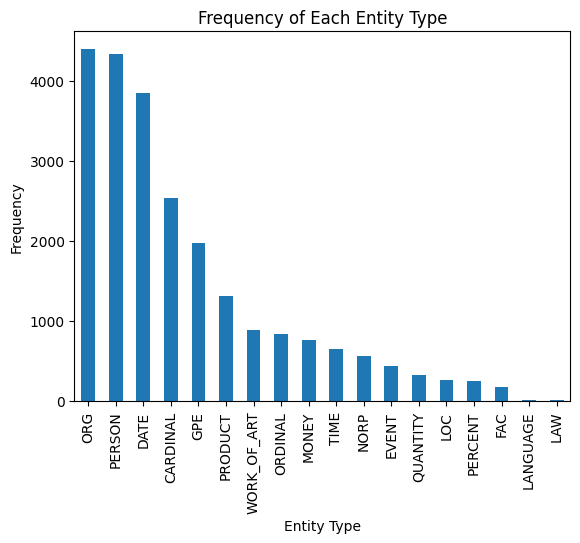

In [137]:
entity_counts = post_data['entities_identified'].explode().value_counts()
sorted_entities = entity_counts.index.to_list()
entity_counts.plot(kind='bar')
plt.title('Frequency of Each Entity Type')
plt.xlabel('Entity Type')
plt.ylabel('Frequency')
plt.show()